In [7]:
from tensorflow.keras import layers
from tensorflow import keras

## Preparing the data

Let's start by downloading the corpus and converting it to lowercase:

In [8]:
import numpy as np

text = open("dril.txt").read().lower()
print('Corpus length:', len(text))

Corpus length: 75219



Next, we will extract partially-overlapping sequences of length `maxlen`, one-hot encode them and pack them in a 3D Numpy array `x` of 
shape `(sequences, maxlen, unique_characters)`. Simultaneously, we prepare a array `y` containing the corresponding targets: the one-hot 
encoded characters that come right after each extracted sequence.

In [9]:
# Length of extracted character sequences
maxlen = 30

# We sample a new sequence every `step` characters
step = 2

# This holds our extracted sequences
sentences = []

# This holds the targets (the follow-up characters)
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))

# List of unique characters in the corpus
chars = sorted(list(set(text)))
print('Unique characters:', len(chars))
# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)

# Next, one-hot encode the characters into binary arrays.
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Number of sequences: 37595
Unique characters: 191
Vectorization...


In [10]:
split = .2
max_train_ind = np.floor(x.shape[0]*(1-split)).astype(int)
x_train = x[:max_train_ind]
x_test = x[max_train_ind:]
y_train = y[:max_train_ind]
y_test = y[max_train_ind:]

## Building the network

Our network uses 2 stacked `GRU` layers followed by a `Dense` classifier and softmax over all possible characters. 

In [11]:
model = keras.models.Sequential()
model.add(layers.GRU(32, input_shape=(maxlen, len(chars)),return_sequences=True))
model.add(layers.GRU(32))
model.add(layers.Dropout(.2))
model.add(layers.Dense(len(chars), activation='softmax'))

Since our targets are one-hot encoded, we will use `categorical_crossentropy` as the loss to train the model:

In [12]:
optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ['acc'])

## Training the language model and sampling from it


Given a trained model and a seed text snippet, we generate new text by repeatedly:

* 1) Drawing from the model a probability distribution over the next character given the text available so far
* 2) Reweighting the distribution to a certain "temperature"
* 3) Sampling the next character at random according to the reweighted distribution
* 4) Adding the new character at the end of the available text

This is the code we use to reweight the original probability distribution coming out of the model, 
and draw a character index from it (the "sampling function"):

In [13]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

Create a callback for early stopping

In [14]:
callbacks = [keras.callbacks.EarlyStopping(monitor = "val_loss",
patience = 5,
mode = 'min')]

Train Model

In [15]:
history = model.fit(x_train, y_train, batch_size = 128, epochs = 40, validation_data = (x_test, y_test), callbacks = callbacks)

Train on 30076 samples, validate on 7519 samples
Epoch 1/40
30076/30076 [==============================] - 17s 569us/step - loss: 2.8069 - acc: 0.2437 - val_loss: 2.5216 - val_acc: 0.3092
Epoch 2/40
30076/30076 [==============================] - 15s 515us/step - loss: 2.4623 - acc: 0.3183 - val_loss: 2.3806 - val_acc: 0.3340
Epoch 3/40
30076/30076 [==============================] - 16s 516us/step - loss: 2.3575 - acc: 0.3440 - val_loss: 2.3289 - val_acc: 0.3607
Epoch 4/40
30076/30076 [==============================] - 15s 508us/step - loss: 2.2884 - acc: 0.3603 - val_loss: 2.2809 - val_acc: 0.3774
Epoch 5/40
30076/30076 [==============================] - 16s 529us/step - loss: 2.2414 - acc: 0.3743 - val_loss: 2.2620 - val_acc: 0.3802
Epoch 6/40
30076/30076 [==============================] - 16s 537us/step - loss: 2.1997 - acc: 0.3803 - val_loss: 2.2605 - val_acc: 0.3797
Epoch 7/40
30076/30076 [==============================] - 16s 518us/step - loss: 2.1651 - acc: 0.3912 - val_loss: 2.2

In [16]:
model.save('text-model.h5')

Outputs a random sample

In [77]:
import random
import sys


def output_sample(temperatures,rand_temperatures, sample_length):
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated_text = text[start_index: start_index + maxlen]
    
    print('--- Generating with seed: "' + generated_text + '"')
    
    for temperature in temperatures:
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)
        
        for i in range(sample_length):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
    
    
    print('------ temperature: random')
    sys.stdout.write(generated_text)
    for i in range(sample_length):
        sampled = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(generated_text):
            sampled[0, t, char_indices[char]] = 1.
        
        temperature = np.random.choice(rand_temperatures)
        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1:]

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()


In [78]:
temperatures = [.1,.2,.5,.7,1.0,1.2]
sample_length = 500
rand_temperatures = [.3,.4,.5,.6]
output_sample(temperatures, rand_temperatures, sample_length)

--- Generating with seed: "reeway and letting cars run ov"
------ temperature: 0.1
reeway and letting cars run ove to the shit to the come to the come to the come the book of the been the book of the con the book of the been the like it to the come to the come to the shit hell at how the con the book of the book of the book of the come to the come the all the come to the chated to the conter the book of the come to the chated to the come to the book of the come to the come to the come to the come the book of the book of the come to the conter the comm ang to the book of the show the con the book of the bea
------ temperature: 0.2
ow the con the book of the beat the conter the conter the mothe conter to the car and the bit to the book it sime the been i of me ass of my stated the been to the come to bat and the show to the shit him of the been to be my to the will to the mollount to the come to the conter the mothe of the conger of the me to the chowed to the conter the shit the been to


As you can see, a low temperature results in extremely repetitive and predictable text, but where local structure is highly realistic: in 
particular, all words (a word being a local pattern of characters) are real English words. With higher temperatures, the generated text 
becomes more interesting, surprising, even creative; it may sometimes invent completely new words that sound somewhat plausible (such as 
"eterned" or "troveration"). With a high temperature, the local structure starts breaking down and most words look like semi-random strings 
of characters. Without a doubt, here 0.5 is the most interesting temperature for text generation in this specific setup. Always experiment 
with multiple sampling strategies! A clever balance between learned structure and randomness is what makes generation interesting.

Note that by training a bigger model, longer, on more data, you can achieve generated samples that will look much more coherent and 
realistic than ours. But of course, don't expect to ever generate any meaningful text, other than by random chance: all we are doing is 
sampling data from a statistical model of which characters come after which characters. Language is a communication channel, and there is 
a distinction between what communications are about, and the statistical structure of the messages in which communications are encoded. To 
evidence this distinction, here is a thought experiment: what if human language did a better job at compressing communications, much like 
our computers do with most of our digital communications? Then language would be no less meaningful, yet it would lack any intrinsic 
statistical structure, thus making it impossible to learn a language model like we just did.


## Take aways

* We can generate discrete sequence data by training a model to predict the next tokens(s) given previous tokens.
* In the case of text, such a model is called a "language model" and could be based on either words or characters.
* Sampling the next token requires balance between adhering to what the model judges likely, and introducing randomness.
* One way to handle this is the notion of _softmax temperature_. Always experiment with different temperatures to find the "right" one.

In [19]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(text)

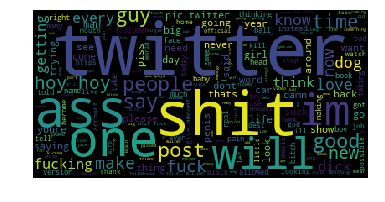

In [108]:
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("wordcloud.png", interpolation = 'bilinear')
plt.show()

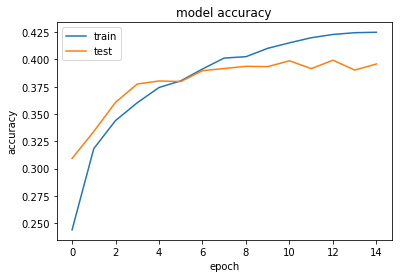

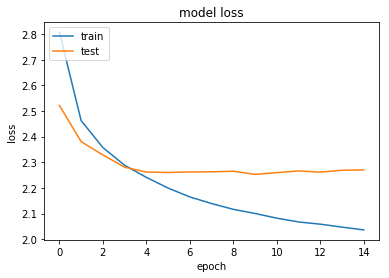

In [79]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_accuracy.png')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_loss.png')
plt.show()

In [80]:
y_pred = model.predict(x_test)

In [95]:
from collections import Counter
count = Counter(text)
num_chars = 40
most_common_chars_count = count.most_common()[0:num_chars]
most_common_inds = []
for i in range(len(most_common_chars_count)):
    for j in range(len(chars)):
        if chars[j] == most_common_chars_count[i][0]:
            most_common_inds.append(j)
            break
most_common_inds.sort()
most_common_chars = []
for i in most_common_inds:
    most_common_chars.append(chars[i])
most_common_chars


['\n',
 ' ',
 '!',
 '"',
 "'",
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '5',
 ':',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [96]:
preds_subset = y_pred[:,most_common_inds]
test_subset = y_test[:,most_common_inds]

In [97]:
from sklearn import metrics
matrix = metrics.confusion_matrix(preds_subset.argmax(axis=1), test_subset.argmax(axis=1))

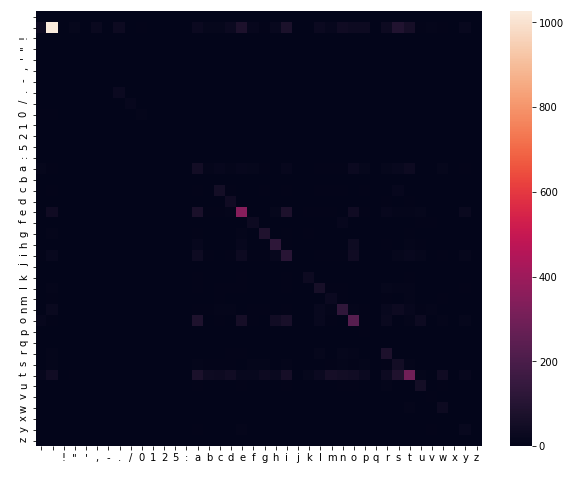

In [106]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame(matrix, range(num_chars), range(num_chars))
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
sns_plot = sns.heatmap(df, xticklabels = most_common_chars, yticklabels = most_common_chars)
fig = sns_plot.get_figure()
fig.savefig("confusion matrix.png")